In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from matplotlib.colors import ListedColormap

sns.set_style('white')

plt.rc('font', family='sans-serif')
plt.rc('font', serif='Arial')
plt.rc('text', usetex='false')

try:
    plt.style.use('../custom.mplstyle')
except IOError:
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=12, titlesize=12)
    plt.rc('legend', fontsize=8)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from ete3 import Tree

In [3]:
def expected(values, pseudo):
    return sum(np.log(1 - values + pseudo))/values.shape[0]

In [4]:
def get_tree(infile):
    tree = Tree(infile)

    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.replace("'", '').split('.')[0]
        if x.name == 'genome':
            x.name = 'NT12001_189'
    strains = {x.name.split('_')[0]
               for x in tree.traverse()
               if x.is_leaf()}
    for s in strains:
        nodes = sorted([x
                        for x in tree.traverse()
                        if x.name.startswith(s)],
                       key=lambda x: x.name)
        if len(nodes) == 1:
            continue
        for node in nodes[1:]:
            node.delete()
    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.split('_')[0]
    tree.set_outgroup(tree.get_midpoint_outgroup())

    return tree

In [5]:
tree = get_tree('../input/tree.nwk')

In [6]:
p = pd.read_table('../sickness/123456/all.txt')
p.set_index('prot', inplace=True)
p[np.isnan(p)] = 0
p1 = p / -p.apply(expected, pseudo=0.0)
p = p.T
p1 = p1.T

In [7]:
for x in tree.traverse():
    if not x.is_leaf():
        continue
    if x.name == 'NT12001':
        break
res = []
for y in tree.traverse():
    if not y.is_leaf():
        continue
    if y.name not in set(p.index):
        continue
    res.append((tree.get_distance(x, y),
                p.loc[y.name].mean(),
                p.loc[y.name].median(),
                p.loc[y.name].mad(),
                'uncorrected'))
    res.append((tree.get_distance(x, y),
                p1.loc[y.name].mean(),
                p1.loc[y.name].median(),
                p1.loc[y.name].mad(),
                'corrected'))
r = pd.DataFrame(res)
r.columns = ['dist', 'sick', 'msick', 'mad', 'kind']

In [8]:
r = r.dropna()

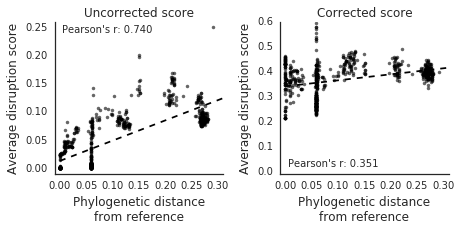

In [9]:
plt.figure(figsize=(6.5, 3.25))

plt.subplot(121)
l = stats.linregress(r[r.kind == 'uncorrected']['dist'],
                     r[r.kind == 'uncorrected']['sick'])
plt.plot(r[r.kind == 'uncorrected']['dist'],
         r[r.kind == 'uncorrected']['sick'],
         'k.',
         alpha=0.6,
         label='_')
fn = l.intercept + l.slope * np.linspace(0, 0.5)
plt.plot(np.linspace(0, 0.5),
         fn,
         'k--')

plt.ylabel('Average disruption score')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.ylim(-0.01, 0.26)
plt.xlim(-0.01, 0.31)

plt.text(0.005,
         0.24,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.title('Uncorrected score')

plt.subplot(122)
l = stats.linregress(r[r.kind == 'corrected']['dist'],
                     r[r.kind == 'corrected']['sick'])
plt.plot(r[r.kind == 'corrected']['dist'],
         r[r.kind == 'corrected']['sick'],
         'k.',
         alpha=0.6,
         label='_')
fn = l.intercept + l.slope * np.linspace(0, 0.5)
plt.plot(np.linspace(0, 0.5),
         fn,
         'k--')

plt.ylabel('Average disruption score')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.ylim(-0.01, 0.6)
plt.xlim(-0.01, 0.31)

plt.text(0.005,
         0.02,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.title('Corrected score')

sns.despine()
plt.tight_layout()
plt.savefig('sfig2a.svg', dpi=150)

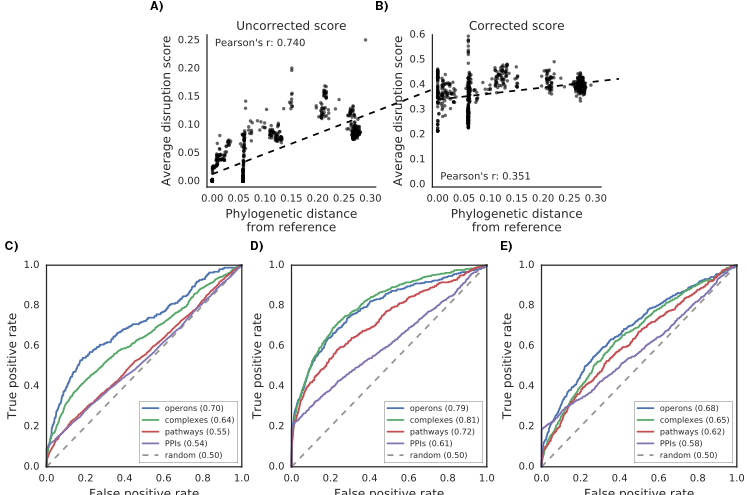

In [10]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("8.3in", "5.5in")

# load matpotlib-generated figures
fig3 = sg.fromfile('sfig2a.svg')
fig0 = sg.fromfile('../plots/sickness_roc.svg')
fig1 = sg.fromfile('../plots/sickness_roc_accessory.svg')
fig2 = sg.fromfile('../plots/sickness_roc_snps_accessory.svg')

# get the plot objects
plot = fig3.getroot()
plot.moveto(150, 10, scale=1)
plot0 = fig0.getroot()
plot0.moveto(15, 240, scale=1)
plot1 = fig1.getroot()
plot1.moveto(260, 240, scale=1)
plot2 = fig2.getroot()
plot2.moveto(510, 240, scale=1)

# add text labels
txt = sg.TextElement(150, 10, "A)", size=12, weight="bold")
txta = sg.TextElement(375, 10, "B)", size=12, weight="bold")
txt1 = sg.TextElement(5, 250, "C)", size=12, weight="bold")
txt2 = sg.TextElement(250, 250, "D)", size=12, weight="bold")
txt3 = sg.TextElement(500, 250, "E)", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot,
            plot2,
            plot1,
            plot0,
           ])
fig.append([txt,
            txta,
            txt1,
            txt2,
            txt3,
           ])

# save generated SVG files
fig.save("../figures/supplementary/sfig2.svg")

!convert ../figures/supplementary/sfig2.svg sfig2.png

from IPython.display import Image
Image(filename='sfig2.png')